## Run MD with vanilla/og system and then check that difference in energies between vanilla vs rest system are close to 0

In [1]:
from tqdm import tqdm_notebook
import openmmtools
import matplotlib.pyplot as plt
import pickle

from simtk import openmm
from simtk.openmm import unit
import openmmtools
from openmmtools.states import SamplerState, ThermodynamicState, CompoundThermodynamicState
from openmmtools import cache

from perses.annihilation.rest import RESTTopologyFactoryV3
from perses.annihilation.lambda_protocol import RESTStateV3
from perses.dispersed import feptasks

import numpy as np

In [4]:
with open("T42A_complex_0.pickle", "rb") as f:
    htf = pickle.load(f)

In [5]:
# Create REST-ified hybrid system
rest_atoms = list(htf._atom_classes['unique_old_atoms']) + list(htf._atom_classes['unique_new_atoms'])
factory = RESTTopologyFactoryV3(htf.hybrid_system, htf.hybrid_topology, rest_region=rest_atoms, use_dispersion_correction=True)
REST_system = factory.REST_system

INFO:REST:*** Generating RESTTopologyFactoryV3 ***
INFO:REST:No unknown forces.
INFO:REST:alpha_ewald is 2.7569734238004693
INFO:REST:Added MonteCarloBarostat.
INFO:REST:getDefaultPeriodicBoxVectors added to hybrid: [Quantity(value=Vec3(x=6.7997, y=0.0, z=0.0), unit=nanometer), Quantity(value=Vec3(x=0.0, y=6.7997, z=0.0), unit=nanometer), Quantity(value=Vec3(x=0.0, y=0.0, z=6.7997), unit=nanometer)]


In [7]:
htf.hybrid_system.getForces()

[<openmm.openmm.MonteCarloBarostat; proxy of <Swig Object of type 'OpenMM::MonteCarloBarostat *' at 0x2b5e5c4c0c30> >,
 <openmm.openmm.HarmonicBondForce; proxy of <Swig Object of type 'OpenMM::HarmonicBondForce *' at 0x2b5e5c4c0ae0> >,
 <openmm.openmm.HarmonicAngleForce; proxy of <Swig Object of type 'OpenMM::HarmonicAngleForce *' at 0x2b5e5c4c0990> >,
 <openmm.openmm.PeriodicTorsionForce; proxy of <Swig Object of type 'OpenMM::PeriodicTorsionForce *' at 0x2b5e5c4c0870> >,
 <openmm.openmm.NonbondedForce; proxy of <Swig Object of type 'OpenMM::NonbondedForce *' at 0x2b5e5c4c0810> >]

In [19]:
# Create states for each replica
T_min = 300.0 * unit.kelvin  # Minimum temperature.

# Create thermodynamic state for rest
lambda_zero_alchemical_state = RESTStateV3.from_system(REST_system)
thermostate = ThermodynamicState(REST_system, temperature=T_min)
compound_thermodynamic_state = CompoundThermodynamicState(thermostate, composable_states=[lambda_zero_alchemical_state])

# Create thermodynamic state for og system
thermodynamic_state = ThermodynamicState(htf.hybrid_system, temperature=T_min)


In [20]:
# Create sampler state
sampler_state =  SamplerState(htf.hybrid_positions, box_vectors=htf.hybrid_system.getDefaultPeriodicBoxVectors())

In [7]:
# Minimize sampler state
feptasks.minimize(thermodynamic_state, sampler_state, max_iterations=0)

In [6]:
# Create integrator and context
integrator = openmmtools.integrators.LangevinIntegrator(temperature=300 * unit.kelvin,
                                              collision_rate=1 / unit.picoseconds,
                                              timestep= 4 * unit.femtoseconds)
context_cache = cache.global_context_cache
context, integrator = context_cache.get_context(thermodynamic_state, integrator)
sampler_state.apply_to_context(context)


In [10]:
# Run MD
hybrid = list()
for _ in tqdm_notebook(range(int(125000/250))):
    integrator.step(250)
    pos = context.getState(getPositions=True, enforcePeriodicBox=False).getPositions(asNumpy=True)
    hybrid.append(pos)

/scratch/lsftmp/3123035.tmpdir/ipykernel_54653/3402924903.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _ in tqdm_notebook(range(int(125000/250))):


  0%|          | 0/500 [00:00<?, ?it/s]

In [11]:
with open("hybrid_positions_bnbs.pickle", "wb") as f:
    pickle.dump(hybrid, f)

In [16]:
with open("hybrid_positions_bnbs.pickle", "rb") as f:
    hybrid = pickle.load(f)

In [25]:
# Make context for og system
integrator_og = openmmtools.integrators.LangevinIntegrator(temperature=300 * unit.kelvin,
                                          collision_rate=1 / unit.picoseconds,
                                          timestep= 4 * unit.femtoseconds)
context_og = thermodynamic_state.create_context(integrator_og)

# Make context for rest system
integrator_rest = openmmtools.integrators.LangevinIntegrator(temperature=300 * unit.kelvin,
                                          collision_rate=1 / unit.picoseconds,
                                          timestep= 4 * unit.femtoseconds)
context_rest = compound_thermodynamic_state.create_context(integrator_rest)

# Get energies for each conformation
energies_og = list()
energies_rest = list()
for pos in tqdm_notebook(hybrid):
   
    context_og.setPositions(pos)
    energy_og = context_og.getState(getEnergy=True).getPotentialEnergy()
    energies_og.append(energy_og.value_in_unit_system(unit.md_unit_system))
    
    context_rest.setPositions(pos)
    energy_rest = context_rest.getState(getEnergy=True).getPotentialEnergy()
    energies_rest.append(energy_rest.value_in_unit_system(unit.md_unit_system))
    
    print(energy_og, energy_rest)

/scratch/lsftmp/3123035.tmpdir/ipykernel_58087/3539275421.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for pos in tqdm_notebook(hybrid):


  0%|          | 0/500 [00:00<?, ?it/s]

-418082.11703982763 kJ/mol -418082.18151583243 kJ/mol
-392938.0107344417 kJ/mol -392938.1042134748 kJ/mol
-380756.91127605503 kJ/mol -380757.0325586782 kJ/mol
-374784.6158661619 kJ/mol -374784.7429394489 kJ/mol
-371046.9308533659 kJ/mol -371047.0592889341 kJ/mol
-365507.5304442998 kJ/mol -365507.6630748138 kJ/mol
-363652.3935458404 kJ/mol -363652.5332655292 kJ/mol
-363982.9916020478 kJ/mol -363983.12394221104 kJ/mol
-360229.52564656036 kJ/mol -360229.65314135933 kJ/mol
-361075.40090982546 kJ/mol -361075.5345182903 kJ/mol
-358302.31882725144 kJ/mol -358302.4557951959 kJ/mol
-361633.21517098695 kJ/mol -361633.3492552885 kJ/mol
-357821.6133601726 kJ/mol -357821.7496636708 kJ/mol
-361788.95115922997 kJ/mol -361789.08203412336 kJ/mol
-359727.29901723284 kJ/mol -359727.4281156135 kJ/mol
-356200.36475964356 kJ/mol -356200.50057625654 kJ/mol
-354103.9897411284 kJ/mol -354104.12086571776 kJ/mol
-356896.1822826413 kJ/mol -356896.31085646106 kJ/mol
-356850.4834829429 kJ/mol -356850.61670652614 kJ

-356444.96001434047 kJ/mol -356445.0901783393 kJ/mol
-358666.2033898304 kJ/mol -358666.33746299334 kJ/mol
-356181.59599691816 kJ/mol -356181.732389563 kJ/mol
-358739.1103735226 kJ/mol -358739.24285937124 kJ/mol
-360906.0167785324 kJ/mol -360906.15133160935 kJ/mol
-361008.37326793093 kJ/mol -361008.50612710323 kJ/mol
-352316.32000416843 kJ/mol -352316.4601345528 kJ/mol
-358872.127689268 kJ/mol -358872.25816000113 kJ/mol
-337162.4452064072 kJ/mol -337162.5863937745 kJ/mol
-355211.7198264161 kJ/mol -355211.85335624265 kJ/mol
-357940.98448471446 kJ/mol -357941.12729620445 kJ/mol
-359687.56677684 kJ/mol -359687.7047848529 kJ/mol
-359824.2723767378 kJ/mol -359824.4060226246 kJ/mol
-359949.82732687984 kJ/mol -359949.96088357875 kJ/mol
-356510.7596431491 kJ/mol -356510.8785144582 kJ/mol
-356926.2899457873 kJ/mol -356926.42430868675 kJ/mol
-349849.424889741 kJ/mol -349849.55402949546 kJ/mol
-352582.4232033971 kJ/mol -352582.55389880855 kJ/mol
-357821.78057242394 kJ/mol -357821.90387855424 kJ/mo

-360413.6835132383 kJ/mol -360413.81495988695 kJ/mol
-358624.3828151128 kJ/mol -358624.5163806109 kJ/mol
-359123.26214065077 kJ/mol -359123.38628974766 kJ/mol
-358700.2078735526 kJ/mol -358700.3407763955 kJ/mol
-361302.92881256784 kJ/mol -361303.0671274536 kJ/mol
-360757.44409872196 kJ/mol -360757.57286276994 kJ/mol
-353467.72779782536 kJ/mol -353467.8601108664 kJ/mol
-356036.8492090425 kJ/mol -356036.97861097753 kJ/mol
-360982.4943249603 kJ/mol -360982.62617882877 kJ/mol
-359960.4862547871 kJ/mol -359960.6144952758 kJ/mol
-357494.1105545552 kJ/mol -357494.2354886541 kJ/mol
-359567.60370377963 kJ/mol -359567.73189086886 kJ/mol
-360292.2530777864 kJ/mol -360292.38978663227 kJ/mol
-358560.68311836384 kJ/mol -358560.82055056514 kJ/mol
-281749.167946917 kJ/mol -281749.2956030918 kJ/mol
-355457.82182115386 kJ/mol -355457.952120075 kJ/mol
-350385.4357897381 kJ/mol -350385.55929786246 kJ/mol
-348694.32114540366 kJ/mol -348694.4488745574 kJ/mol
-355473.8332846854 kJ/mol -355473.9637036293 kJ/m

-359645.08017791715 kJ/mol -359645.2136491756 kJ/mol
-356944.7643715644 kJ/mol -356944.89266941906 kJ/mol
-360108.3376098275 kJ/mol -360108.4670965653 kJ/mol
-350924.24205142516 kJ/mol -350924.3717396816 kJ/mol
-351296.30465493957 kJ/mol -351296.4329178934 kJ/mol
-334296.58153139707 kJ/mol -334296.7150345994 kJ/mol
-360718.4303769949 kJ/mol -360718.562015197 kJ/mol
-360798.45529091405 kJ/mol -360798.58693440445 kJ/mol
-358598.3803375985 kJ/mol -358598.51488873083 kJ/mol
-359164.0634937221 kJ/mol -359164.1999063436 kJ/mol
-360293.59617076674 kJ/mol -360293.72692729253 kJ/mol
-354285.8073306093 kJ/mol -354285.9326073753 kJ/mol


Text(0.5, 0, 'snapshot #')

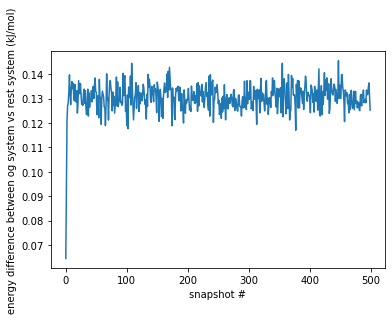

In [30]:
plt.plot(np.array(energies_og) - np.array(energies_rest))
plt.ylabel("energy difference between og system vs rest system (kJ/mol)")
plt.xlabel("snapshot #")

In [31]:
print(np.array(energies_og) - np.array(energies_rest))


[0.064476   0.09347903 0.12128262 0.12707329 0.12843557 0.13263051
 0.13971969 0.13234016 0.1274948  0.13360846 0.13696794 0.1340843
 0.1363035  0.13087489 0.12909838 0.13581661 0.13112459 0.12857382
 0.13322358 0.1240618  0.1278791  0.13738034 0.13484382 0.13192726
 0.13617473 0.1322037  0.12767744 0.12793929 0.12721262 0.13213502
 0.13387695 0.12805582 0.13325642 0.12643435 0.12346151 0.12645197
 0.13385597 0.12285594 0.13234868 0.12640457 0.12971684 0.12994514
 0.13326778 0.12861735 0.13353101 0.13500767 0.1300238  0.13514637
 0.13846508 0.13294483 0.13257448 0.12337506 0.12956961 0.13121232
 0.12216549 0.1378949  0.13044471 0.13033916 0.1194572  0.13017577
 0.13304239 0.13192298 0.13071461 0.12656385 0.12624244 0.11889409
 0.12721639 0.14014988 0.12937258 0.13039877 0.12120269 0.13173889
 0.1362603  0.13744223 0.13426922 0.13235885 0.12494848 0.13265534
 0.12718728 0.13083176 0.12399667 0.12714983 0.13018646 0.13882801
 0.12700679 0.13680597 0.12672748 0.12871187 0.12927132 0.13460

In [27]:
np.std(np.array(energies_og) - np.array(energies_rest))

0.005789720133556094

In [28]:
with open("energies_bnbs_rest.pickle", "wb") as f:
    pickle.dump(energies_rest, f)
with open("energies_bnbs_og.pickle", "wb") as f:
    pickle.dump(energies_og, f)